In [1]:
import pandas as pd

# Crime data set

👉🏼 Immediately use API field names as column names b/c the original column headers are in UPPERCASE

In [ ]:
api_names = ['agency_name', 'incident_number', 'charge_id', 'supplemental', 'charge_date', 'report_date', 'approved_date', 'attempted_committed', 'street', 'street_2', 'city', 'state', 'postal_code', 'district', 'zone', 'sub_zone', 'statute_title', 'statute_description', 'statute_category', 'crime_against', 'nibrs_code', 'offense_description', 'census_block_group', 'council_district', 'crime_prevention_district', 'neighborhood', 'longitude', 'latitude', 'enforcement_agency_id', 'geolocation']

## Initial read

In [52]:
so_pd_crimes = pd.read_csv('EBRP_Combined_Crime_Incidents.csv',
                           header=0,
                           names=api_names)

so_pd_crimes.shape

(276956, 30)

Capture the memory usage

In [53]:
raw_frame_memory = so_pd_crimes.memory_usage(index=True, deep=True).sum()
print(f'{raw_frame_memory:,}')

443,995,768


## Additional parameters for `read_csv()`

In [54]:
# Datetime columns
dt_cols = ['charge_date', 'report_date', 'approved_date']

# Columns that will have category data type
cat_cols = ['agency_name', 'attempted_committed', 'city', 'state', 'postal_code', 'district', 'zone', 'sub_zone', 'statute_title', 'statute_category', 'crime_against', 'nibrs_code', 'offense_description', 'council_district', 'crime_prevention_district', 'neighborhood', ]

# Column types that will have String data type
str_cols = ['incident_number', 'charge_id', 'street', 'street_2']

# Create {column_name:dtype} dictonary to pass to dtype argument
str_types = {col_name:'string' for col_name in str_cols}
cat_types = {col_name:"category" for col_name in cat_cols}
dtypes = {**cat_types, **str_types}

# Do not load these columns. They contribute no information.
omit_cols = ['census_block_group', 'geolocation', 'enforcement_agency_id' ]
keep_cols = [col_name for col_name in api_names if col_name not in omit_cols]

In [55]:

so_pd_crimes = pd.read_csv('EBRP_Combined_Crime_Incidents.csv',
                           header=0,
                           names=api_names,
                           parse_dates=dt_cols,
                           usecols=keep_cols,
                           dtype=dtypes)

C:\Users\jlefe\AppData\Local\Temp\ipykernel_16600\1069470106.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  so_pd_crimes = pd.read_csv('EBRP_Combined_Crime_Incidents.csv',
C:\Users\jlefe\AppData\Local\Temp\ipykernel_16600\1069470106.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  so_pd_crimes = pd.read_csv('EBRP_Combined_Crime_Incidents.csv',


Capture the memory usage of the new dataframe

In [56]:
reduced_frame_memory = so_pd_crimes.memory_usage(index=True, deep=True).sum()
print(f'{reduced_frame_memory:,}')

120,225,482


### Memory improvement

In [57]:
print(f'{raw_frame_memory / reduced_frame_memory}')


3.6930254769117914


## Remove rows with charge_date prior to 2021-01-01

These are crimes that occured prior to 2021 but weren't reported until later

In [58]:
so_pd_crimes = so_pd_crimes[so_pd_crimes.charge_date.dt.year >= 2021]

## Reduce dataframe to only Saturdays during football season (Sept - Dec)

Make a copy to avoid slice warnings.

In [30]:
crimes_fb_sat = so_pd_crimes[(so_pd_crimes.charge_day.dt.month.isin([9, 10, 11, 12])) & (so_pd_crimes.charge_day.dt.day_of_week == 5)].copy()

In [75]:
crimes_fb_sat.sample(15).to_csv('sample_crimes.csv')

### Remove the old dataframe to release memory

https://stackoverflow.com/questions/32247643/how-to-delete-multiple-pandas-python-dataframes-from-memory-to-save-ram

In [32]:
import gc

del so_pd_crimes
gc.collect()
so_pd_crimes=pd.DataFrame()

# LSU football schedule

The crime data set starts in 2021.  Use football seasons 2021-2023.

In [59]:
#  NB: Date column, changed "Sept." to "Sep" in Excel first :P
schedule = pd.read_csv('lsu_football_schedule_2020_2023.csv', parse_dates=["Date"], date_format='%b. %d, %Y')
schedule.columns=['game_date', 'game_location', 'game_result']
schedule.head()

,game_date,game_location,game_result
0,2022-01-04,"Houston, Texas","Kansas State 42, LSU 20"
1,2021-11-27,"Baton Rouge, La.","LSU 27, #14 Texas A&M 24"
2,2021-11-20,"Baton Rouge, La.","LSU 27, ULM 14"
3,2021-11-13,"Baton Rouge, La.","Arkansas 16, LSU 13 (OT)"
4,2021-11-06,"Tuscaloosa, Ala.","#3 Alabama 20, LSU 14"


## Select home games only

In [60]:
home_games = schedule[schedule.game_location == "Baton Rouge, La."].drop(columns=["game_location"])

# Join crime data and game schedule

### Add `charge_day` to crime dataframe as join field 

In [61]:
crimes_fb_sat['charge_day'] = crimes_fb_sat['charge_date'].dt.floor('d') 


### Join tables

In [62]:
crimes_fb_sat = pd.merge(left=crimes_fb_sat, right=home_games, left_on='charge_day', right_on='game_date', how='left')
crimes_fb_sat['home_game'] = crimes_fb_sat['game_date'].notnull()
crimes_fb_sat.drop(columns=["game_date"], inplace=True)

# Crime incidents
- Keep incident ids only, not using other data at this time.
- `drop_duplicates()`: An incident can have more than one crime, i.e., more than one row in the database

In [63]:
incidents = crimes_fb_sat[['incident_number', 'charge_day', 'home_game']].drop_duplicates()

## Incident counts

In [64]:
incident_counts = incidents.groupby(['charge_day', 'home_game']).count().rename(columns={'incident_number':'incident_count'}).reset_index(level=1)


## EDA

In [68]:
print(incident_counts.groupby('home_game')['incident_count'].describe())

           count        mean        std    min    25%    50%    75%    max
home_game                                                                 
False       35.0  131.085714  32.905722   22.0  121.0  143.0  152.0  173.0
True        21.0  144.904762  15.908818  115.0  132.0  145.0  156.0  172.0


In [69]:
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

C:\Users\jlefe\AppData\Local\Temp\ipykernel_16600\517460460.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=incident_counts, x="home_game", y="incident_count", palette=["#461D7C", "#FDD023"])


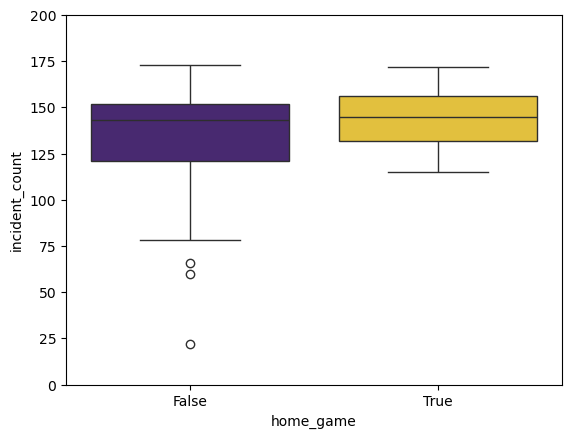

In [70]:
sns.boxplot(data=incident_counts, x="home_game", y="incident_count", palette=["#461D7C", "#FDD023"])
plt.ylim(0,200)
plt.show()

<Axes: ylabel='incident_count'>

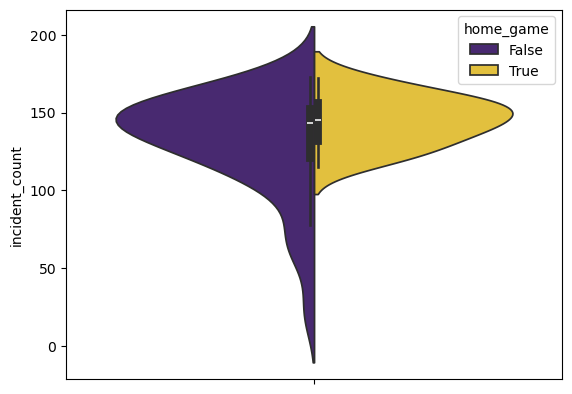

In [71]:
sns.violinplot(data=incident_counts, hue='home_game', split=True, y='incident_count', palette=["#461D7C", "#FDD023"])

# The *t*-test

- H0: On Saturdays during football season, there is no difference between the number of crimes reported when LSU plays at home and when they do not.
- Ha: On Saturdays during football season, there is a difference between the number of crimes reported when LSU plays at home and when they do not.

In [72]:
alpha = 0.05
t, p = stats.ttest_ind(hg_inc_counts, nhg_inc_counts)
print(t, p)

1.797790948060958 0.0778017719338946


## Conclusion

*p* = .078, so we cannot reject the null hypothesis at α = 0.05.  

However, we could reject the null hypothesis at α = 0.10.

Verbally, I would say there is "some" evidence to support the assertion that there are more crimes on home football days.